In [1]:
from utils import *
from extract_feature_AE import *
from extract_feature_PCA import *

In [2]:
import numpy as np
np.random.seed(42)

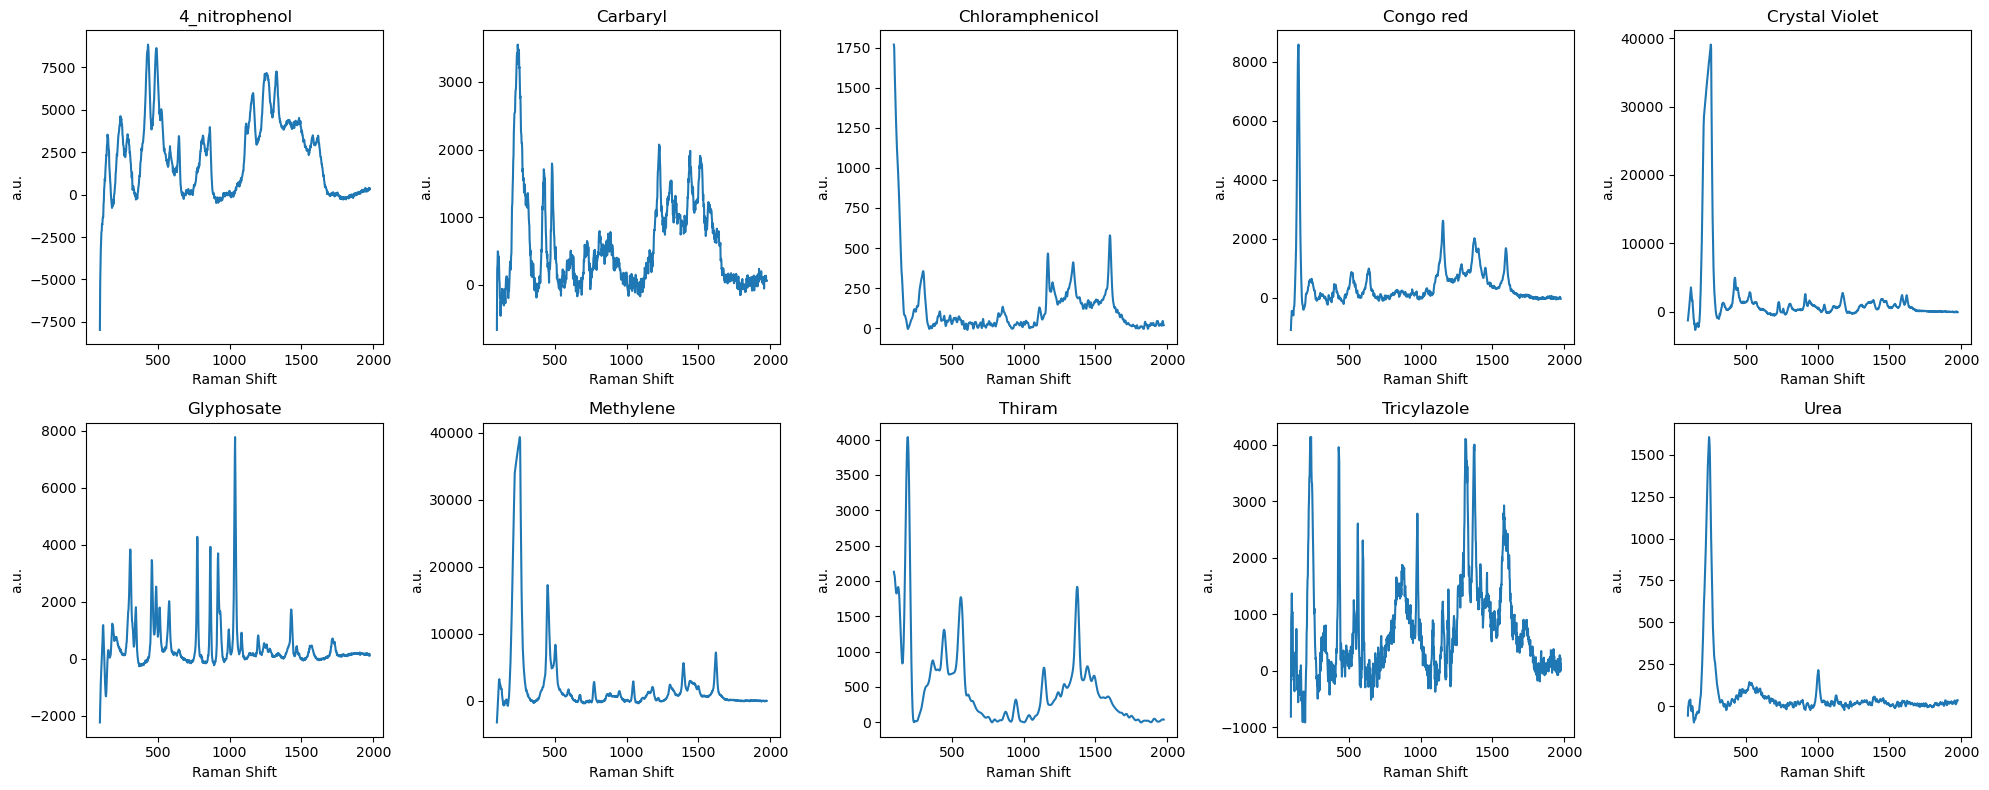

In [3]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

In [5]:
X, y = make_data(paths, 10)
print(X.shape, y.shape)
X_max = X.max(axis = 0, keepdims = True)
X_min = X.min(axis = 0, keepdims = True)

(50, 10) (50, 1)


In [6]:
X = Norm(X)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)

In [10]:
y_test

array([[0.],
       [9.],
       [3.],
       [4.],
       [8.],
       [5.],
       [2.],
       [4.],
       [6.],
       [5.],
       [2.],
       [9.],
       [7.],
       [3.],
       [0.],
       [1.],
       [8.],
       [6.],
       [1.],
       [7.]])

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 10) (30, 1) (20, 10) (20, 1)


# Grid search

In [12]:
Grid_search_model(X_train,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.80
Time taken for Logistic Regression: 0.07 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.63
Time taken for SVM: 0.25 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, score: 0.97
Time taken for KNN: 1.34 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.60
Time taken for Decision Tree: 0.39 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}, score: 0.80
Time taken for Random Forest: 54.05 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.10
Time taken for Naive Bayes:

In [13]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', kernel = 'linear', shrinking = True,  probability=True),
          KNeighborsClassifier(algorithm = 'auto', metric = 'cosine', n_neighbors = 3, p = 1, weights = 'uniform'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 200,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [14]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    file_name = f"./model/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/LogisticRegression.pkl' already saved
Model './model/SVC.pkl' already saved
Model './model/KNeighborsClassifier.pkl' already saved
Model './model/DecisionTreeClassifier.pkl' already saved
Model './model/RandomForestClassifier.pkl' already saved
Model './model/BernoulliNB.pkl' already saved


Testing with SVC
Accuracy: 0.7500
Precision: 0.7567
Recall: 0.7500
F1-score: 0.7205
[2. 9. 3. 4. 8. 5. 2. 4. 7. 5. 2. 9. 7. 3. 0. 4. 8. 6. 2. 2.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


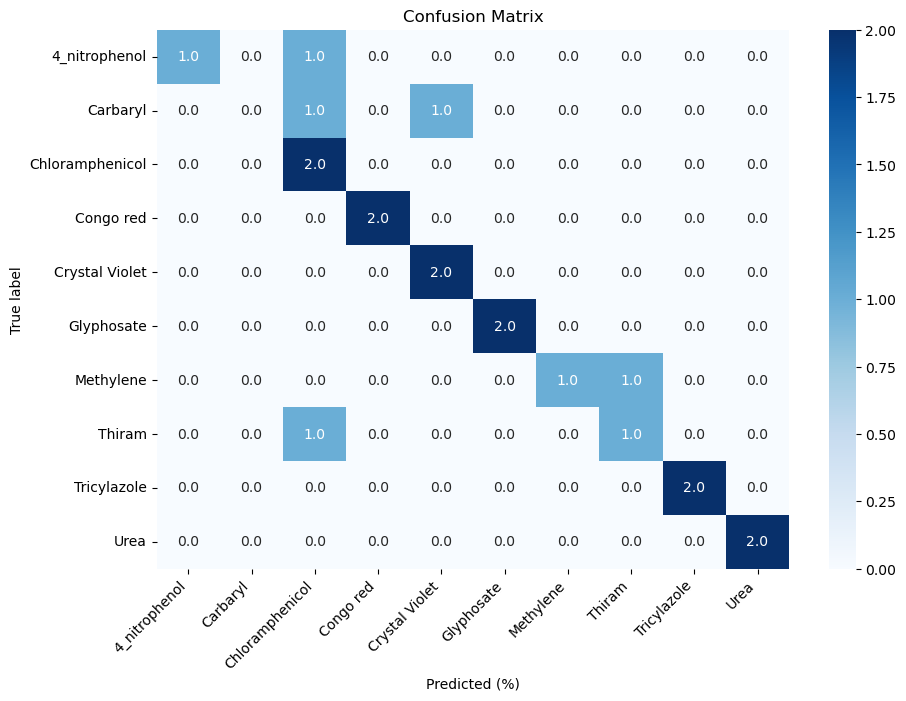

In [29]:
print(model_predict(X_test, y_test, models[1])['Predict'])
print(y_test.T)

# Ensemble

In [30]:
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('knn', models[2]),
    ],
    voting='soft'
)

ensemble_clf.fit(X_train, y_train.ravel())



VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=10, penalty='l1',
                                                 solver='liblinear')),
                             ('knn',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=3, p=1))],
                 voting='soft')

Testing with VotingClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 4. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


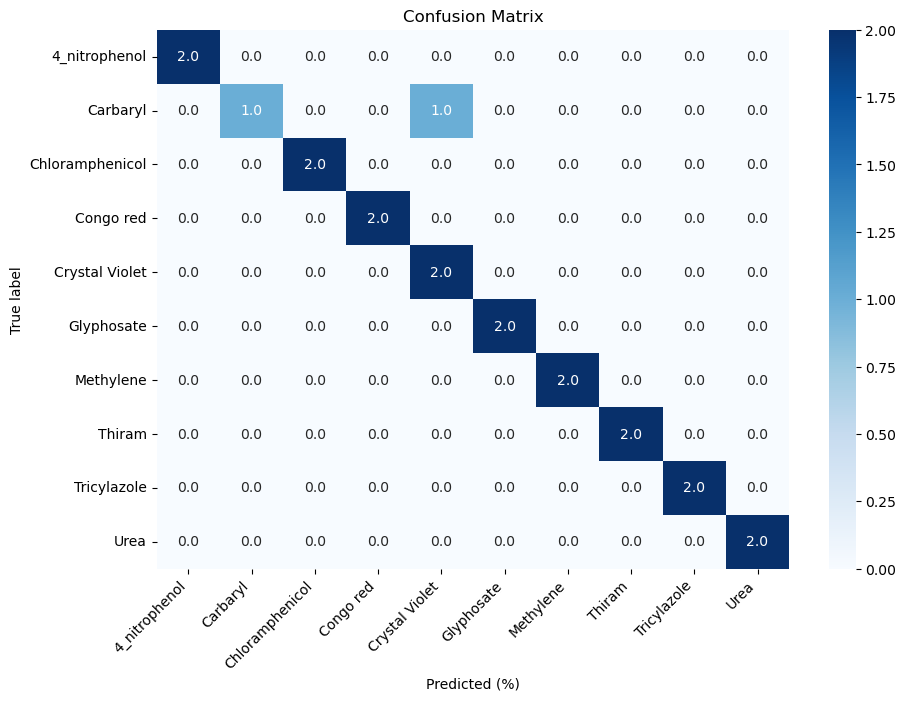

In [31]:
print(model_predict(X_test, y_test, ensemble_clf)['Predict'])
print(y_test.T)

In [32]:
proba = ensemble_clf.predict_proba(X_test)
proba[0]


array([0.63063192, 0.00582993, 0.08515123, 0.03208382, 0.00226757,
       0.00308064, 0.06435023, 0.01938317, 0.00533653, 0.15188496])

# Ensemble + Boosting

In [33]:
from sklearn.ensemble import AdaBoostClassifier
boosting_clf = AdaBoostClassifier(
    estimator=ensemble_clf,
    n_estimators=10,
    learning_rate=1.0
)
boosting_clf.fit(X_train, y_train.ravel())


TypeError: Underlying estimator KNeighborsClassifier does not support sample weights.

Testing with AdaBoostClassifier
Accuracy: 0.9000
Precision: 0.9167
Recall: 0.9000
F1-score: 0.8967
[3. 0. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


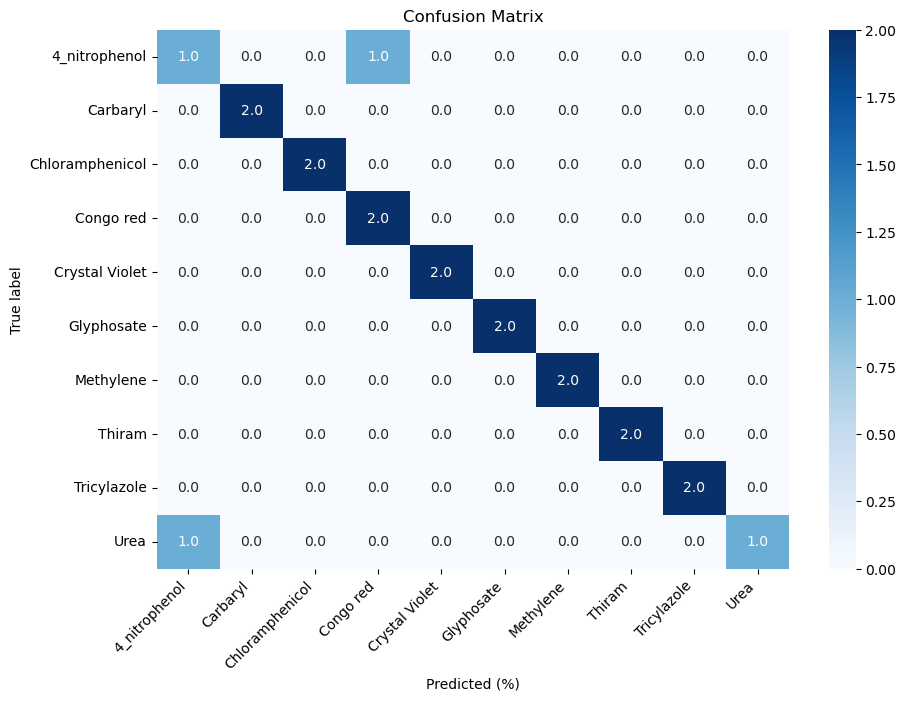

In [44]:
print(model_predict(X_test, y_test, boosting_clf)['Predict'])
print(y_test.T)

# Testing

In [42]:
def model_predict(X_test, y_test, name, path = None, print_eval = True):
    print("Testing with " + type(name).__name__)
    """ If path = None, the model will make predictions on the test set
    , otherwise it will make a prediction on a single sample """
    if path != None:
        data = pd.read_csv(path, sep="\t")
        x = data.iloc[[1886, 1391, 1670, 1407, 1421, 1577, 1878, 1512, 1892, 1596], 1].values
        # x = ((X - X_min) / (X_max - X_min)).reshape(1,X_test.shape[1])
        x = Norm(x).reshape(1,X_test.shape[1])
        # print(x.shape)

    else: x = X_test

    model = name

    predict = model.predict(x)
    proba = model.predict_proba(x)
    probs = [np.round(p, 2) for p in proba]
    
    result = {"Predict": predict, "Class" : [labels[int(p)] for p in predict], "Probability": probs}
    if path == None and print_eval == True:
        evaluate_model(name, X_test, y_test, labels)
    return result

In [51]:
Trycilazole = ['test_Tricylazole/Tricyclazole-1.txt','test_Tricylazole/Tricyclazole-2.txt','test_Tricylazole/Tricyclazole-3.txt',
               'test_Tricylazole/Tricyclazole-4.txt','test_Tricylazole/Tricyclazole-5.txt']
for i in range(5):
    print(model_predict(X_test, y_test, models[0], path = Trycilazole[i])['Predict'])

Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[1.]
Testing with LogisticRegression
[1.]
Testing with LogisticRegression
[1.]


In [52]:
for i in range(5):
    print(model_predict(X_test, y_test, models[1], path = Trycilazole[i])['Predict'])

Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]


In [53]:
for i in range(5):
    print(model_predict(X_test, y_test, models[2], path = Trycilazole[i])['Predict'])

Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]


In [54]:
for i in range(5):
    print(model_predict(X_test, y_test, models[3], path = Trycilazole[i])['Predict'])

Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[3.]
Testing with DecisionTreeClassifier
[1.]
Testing with DecisionTreeClassifier
[0.]
Testing with DecisionTreeClassifier
[2.]


In [55]:
for i in range(5):
    print(model_predict(X_test, y_test, models[4], path = Trycilazole[i])['Predict'])

Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[1.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[1.]


In [56]:
for i in range(5): 
    print(model_predict(X_test, y_test, ensemble_clf, path = Trycilazole[i])['Predict'])

Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[1.]
Testing with VotingClassifier
[8.]


Testing with LogisticRegression


<Axes: >

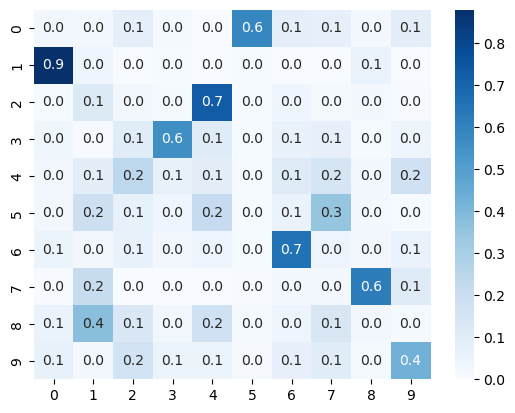

In [49]:
import numpy as np

def calculate_average_probabilities(model):
    result = model_predict(X_test, y_test, model, print_eval = False)
    labels = result["Class"]
    probabilities = result["Probability"]
    
    average_probabilities = []
    for label in set(labels):
        indices = [i for i, value in enumerate(labels) if value == label]
        label_probabilities = np.mean([probabilities[i] for i in indices], axis=0)
        average_probabilities.append(label_probabilities)
    
    return average_probabilities

# Sử dụng hàm calculate_average_probabilities
average_probabilities = calculate_average_probabilities(models[0])
# print(average_probabilities)
import seaborn as sn
sn.heatmap(average_probabilities, annot=True, fmt=".1f", cmap="Blues")

In [74]:
def plot_Tricylazole(paths, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= figsize)
    axes = axes.flatten()

    for i, path in enumerate(paths):
        data = pd.read_csv(path, sep="\t")
        x = data.iloc[-1000:, 0].values
        y = data.iloc[-1000:, 1].values
        ax = axes[i]
        ax.set_xlabel("Raman Shift")
        ax.set_ylabel("a.u.")
        ax.plot(x, y)

    
    plt.tight_layout()  
    plt.show()


In [180]:
def plot_data_norm(paths, labels, file_names, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= figsize)
    axes = axes.flatten()

    for i, path in enumerate(paths):
        path_data = os.path.join(path, file_names)
        data = pd.read_csv(path_data, sep="\t")

        x = my_array = np.arange(10)
        y = data.iloc[[1886, 1391, 1670, 1407, 1421, 1577, 1878, 1512, 1892, 1596], 1].values

        y = np.maximum(y, 0)
        y_min = y.min(axis=0, keepdims=True)
        y_max = y.max(axis=0, keepdims=True)
        y = (y - y_min) / (y_max - y_min)

        ax = axes[i]
        ax.set_xlabel("Raman Shift")
        ax.set_ylabel("a.u.")
        ax.plot(x, y)
    
        ax.set_title(f"{labels[i]}")
    
    plt.tight_layout()  
    plt.show()

[0 1 2 3 4 5 6 7 8 9]
[ 188.624   352.82    344.264   618.009  1204.75     27.8096  110.232
  140.459    74.4258  171.87  ]


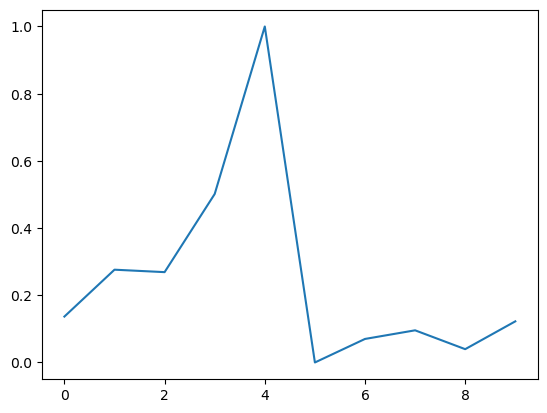

In [59]:
data = pd.read_csv("/home/dotronghiep/Documents/AIoT_Lab/Nano_Data/NanoClassification/test_Tricylazole/Tricyclazole-4.txt", sep="\t")
x = my_array = np.arange(10)
y = data.iloc[[1886, 1391, 1670, 1407, 1421, 1577, 1878, 1512, 1892, 1596], 1].values
print(x)
print(y)
y = np.maximum(y, 0)
y_min = y.min(axis=0, keepdims=True)
y_max = y.max(axis=0, keepdims=True)
y_norm = (y - y_min) / (y_max - y_min)
# y_norm = np.maximum(y_norm, 0.3)
plt.plot(x, y_norm)

In [ ]:
plot_Tricylazole(paths = Trycilazole, nrows=1, ncols=5, figsize = (20, 4))

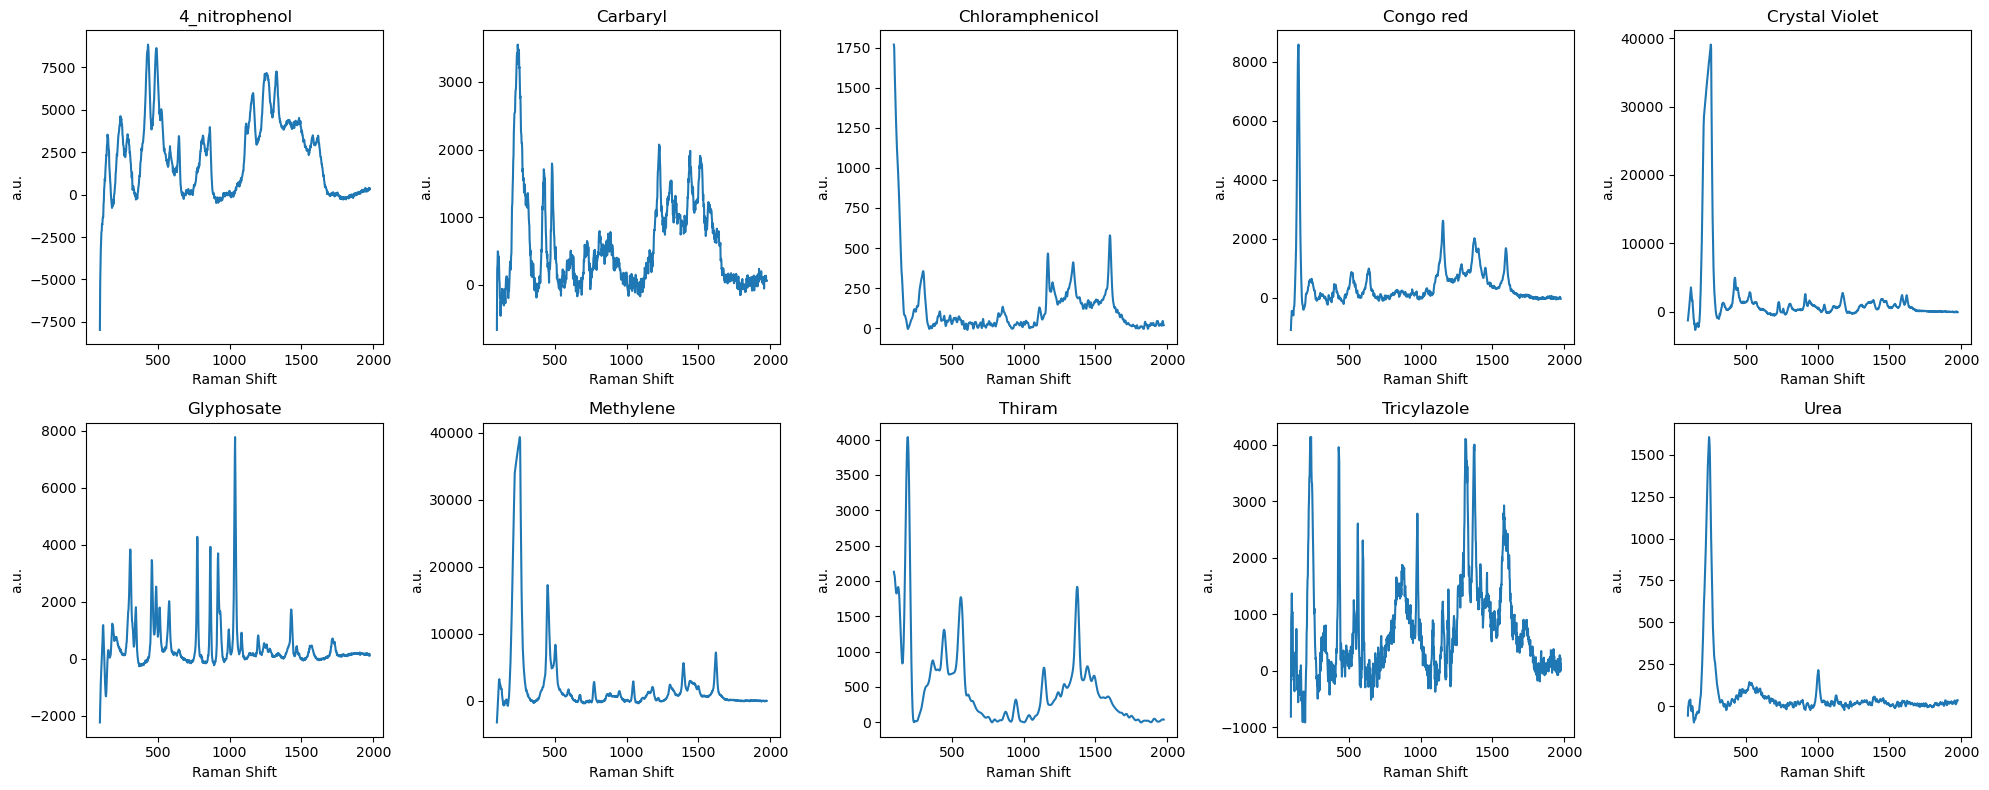

In [54]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

# Feature extraction PCA and training

In [55]:
X_mean = np.mean(X)
U = U_for_pca(X_train, X_mean, n_components = 3)
X_train_PCA = extract_PCA(X_train, X_mean, n_components=3)
# X_test_PCA = pca(X_test, X_mean, U)
X_test_PCA = extract_PCA(X_test, X_mean, n_components=3)

In [56]:
Grid_search_model(X_train_PCA,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.63
Time taken for Logistic Regression: 0.08 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.73
Time taken for SVM: 0.24 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.63
Time taken for KNN: 1.21 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.57
Time taken for Decision Tree: 0.37 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}, score: 0.53
Time taken for Random Forest: 54.07 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.17
Time taken for Naive Bayes: 0.

In [57]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'gini', max_depth= 8, min_samples_leaf= 2, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [58]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/PCA/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/PCA/LogisticRegression.pkl' already saved
Model './model/PCA/SVC.pkl' already saved
Model './model/PCA/KNeighborsClassifier.pkl' already saved
Model './model/PCA/DecisionTreeClassifier.pkl' already saved
Model './model/PCA/RandomForestClassifier.pkl' already saved
Model './model/PCA/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
[5. 5. 5. 1. 5. 4. 7. 8. 0. 4. 7. 5. 2. 7. 5. 5. 5. 8. 7. 4.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


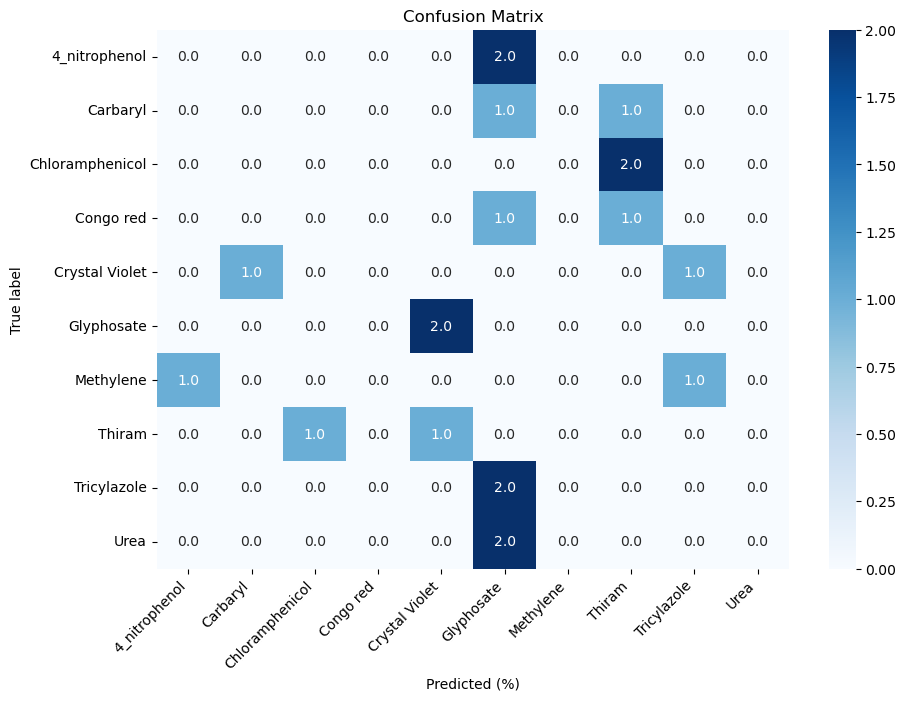

In [59]:
print(model_predict(X_test_PCA, y_test, models[0])['Predict'])
print(y_test.T)

# Feature extraction AutoEncoder and training

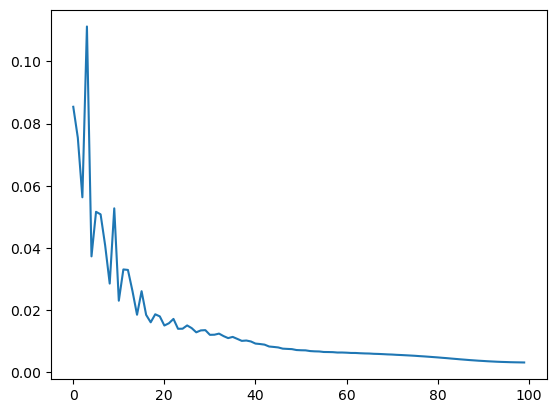

In [60]:
model = modelAE(X_train, out_features = 100, num_epochs = 100, learning_rate = 0.01)

In [61]:
X_train_AE = extractAE(model, X_train)
X_test_AE = extractAE(model, X_test)

In [62]:
Grid_search_model(X_train_AE,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.53
Time taken for Logistic Regression: 0.09 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.57
Time taken for SVM: 0.25 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, score: 0.57
Time taken for KNN: 1.48 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}, score: 0.53
Time taken for Decision Tree: 0.46 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.67
Time taken for Random Forest: 56.49 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.57
Time taken for Naive Baye

In [63]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [64]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_AE, y_train)
    file_name = f"./model/AutoEncoder/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)

Model './model/AutoEncoder/LogisticRegression.pkl' already saved
Model './model/AutoEncoder/SVC.pkl' already saved
Model './model/AutoEncoder/KNeighborsClassifier.pkl' already saved
Model './model/AutoEncoder/DecisionTreeClassifier.pkl' already saved
Model './model/AutoEncoder/RandomForestClassifier.pkl' already saved
Model './model/AutoEncoder/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.2500
Precision: 0.1833
Recall: 0.2500
F1-score: 0.2067
[8. 1. 2. 6. 8. 2. 9. 6. 6. 2. 9. 2. 3. 7. 0. 1. 0. 6. 8. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


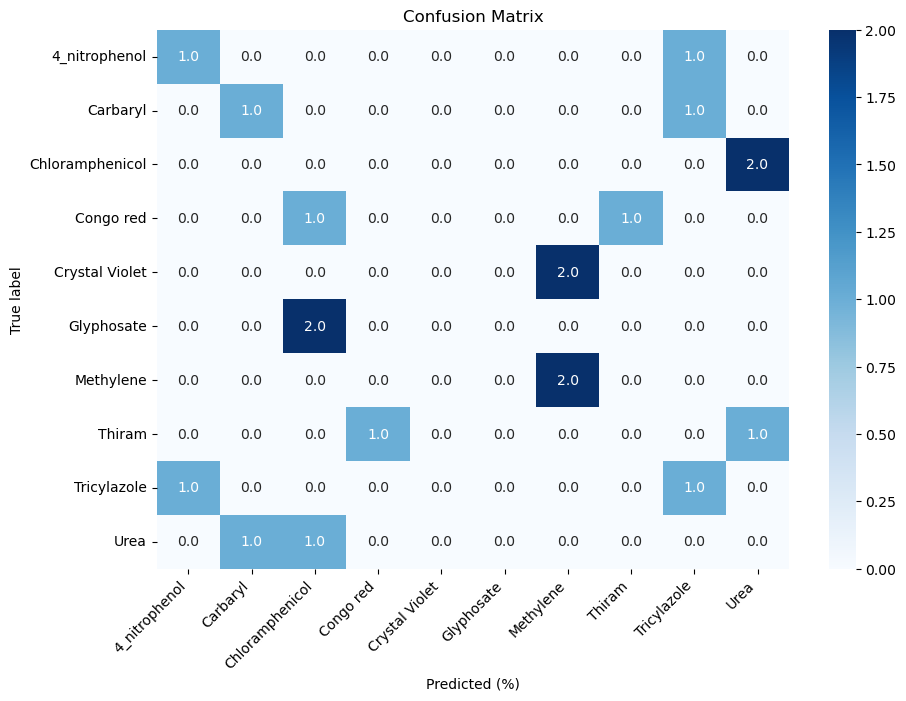

In [65]:
print(model_predict( X_test_AE, y_test, models[0])['Predict'])
print(y_test.T)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)  

X_tsne = tsne.fit_transform(X)


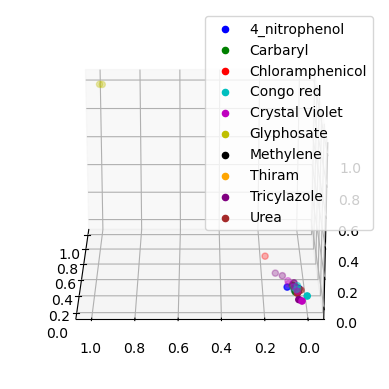

In [67]:
visualize(X,y, option = "3d",eval = 20, azim = 180, legend = True)

In [73]:
a = np.array([-10, 1, 20])
b = np.maximum(a,0)
c = Norm(a)
print(c)

[0.         0.36666667 1.        ]
